# Phase 3 Project: <br> Using Machine Learning for determining Car Accidents causes


<img src="images/Accidents.jpg" alt="drawing" align="left"  width="600"/> 



## OVERVIEW

### The objective of the project :
***
Using traffic accident data published on Chicago Data <br> portal to determine if an accident was caused by a driver

# DATA
The row data consists of 3 datasets:



### [Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)

Crash data shows information about each traffic crash on city streets within the City of Chicago limits 

### [People](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d)

This data contains information about people involved in a crash and if any injuries were sustained.

### [Vehicles](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3)

This dataset contains information about vehicles involved in a traffic crash. 
***


* All three datasets are gziped and saved in data/raw folder


***
# DATA PREPARATION

* People and Vehicles datasets were joined using VEHICLE_ID and CRASH_RECORD_ID
* Crashes dataset was joined with People/Vehicles using CRASH_RECORD_ID
* Datasets were filtered to consider only Drivers (passengers, pedestrians, etc were excluded)
* Data was cleaned  (Rows with unknown or missing data were removed)
* Target variable was bined into two categories: "AT_FAULT" and "NOT_AT_FAULT'

All the steps for Data preparation and cleaning were put into: "initial_prep.py" script

The processed data was generated by initial_prep.py as "crashes.gz" and placed into data/processed folder

***
# MODELING

We considered the following models: 
* Logistic Regression
* Decision Tree
* Extra Tree
* Nearest Neighbor (KNN)
* Random Forest
* Bayesian
* XGBoost


We also tried "bagging" and "voting" Ensembles of the models above

## Features Selection

* We started with 20 features and filtered them one by one until we end up with only 5.

# RESULTS

XGBoost model was chosen as marginally better model (close second and third were Random Forest and Logistic Regression)

In [10]:
# Uncomment only if you want to reprocess the raw data using initial_prep.py
# The script will re-create crashes.gz, comma separated gzipped file in ../data/processed

## %run src/preprocessing/initial_prep.py

In [11]:
# Import required sklearn, pandas, numpy and other libraries:

%run src/import_libraries.py

%matplotlib inline

## Loading processed data

In [12]:
full_df=pd.read_csv('data/processed/crashes.gz', compression='gzip', low_memory=False)
full_df.shape

(348442, 154)

## Defining Training and testing sets

In [13]:
#sample_df=full_df.sample(100000, random_state=100)
sample_df=full_df.copy()

y = sample_df['GUILTY']
x = sample_df.drop(['GUILTY'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=100, test_size=0.35, stratify=y)

nominal_columns = [ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER', 'PHYSICAL_CONDITION', 
                   'TRAFFIC_CONTROL_DEVICE', 'VEHICLE_DEFECT']

X_train = X_train[nominal_columns]
X_test = X_test[nominal_columns]

## Defining a pipeline

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

    
cat_pipeline = Pipeline([
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
         ('std_scaler', StandardScaler()),   
    ])


In [15]:
XGB_pipeline = Pipeline([ ( "cat_pipeline", cat_pipeline ),
                  ('boost', XGBClassifier(use_label_encoder=False, 
                                          eval_metric='auc',  n_estimators=150, n_jobs=-1))
                 ])



pipe_grid={}

gs_pipe = GridSearchCV(estimator=XGB_pipeline, param_grid=pipe_grid,  cv=3, scoring='roc_auc')

## Training and Predicting

In [16]:
gs_pipe.fit(X_train, y_train)
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

# EVALUATION


In [17]:
#print(XGB_pipeline.score(X_train, y_train ))
print(gs_pipe.score(X_train, y_train ))
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

0.8606039887951131
              precision    recall  f1-score   support

           0       0.83      0.87      0.85    145500
           1       0.74      0.68      0.71     80987

    accuracy                           0.80    226487
   macro avg       0.78      0.77      0.78    226487
weighted avg       0.80      0.80      0.80    226487

------------
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     78346
           1       0.73      0.67      0.70     43609

    accuracy                           0.79    121955
   macro avg       0.78      0.77      0.77    121955
weighted avg       0.79      0.79      0.79    121955



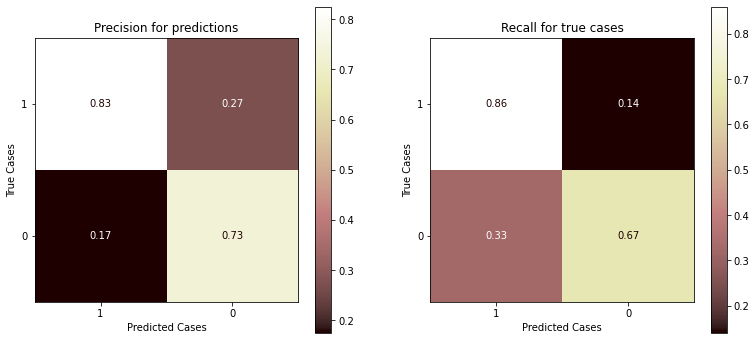

In [18]:
fig, ax = plt.subplots(figsize=(13,6), ncols=2)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='pred', 
                                        display_labels=[1,0],cmap='pink', ax=ax[0])


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true', 
                                        display_labels=[1,0],cmap='pink', ax=ax[1]);

ax[0].set_title("Precision for predictions")
ax[1].set_title("Recall for true cases")

ax[0].set_xlabel('Predicted Cases')
ax[0].set_ylabel('True Cases')
ax[1].set_xlabel('Predicted Cases')
ax[1].set_ylabel('True Cases');

Our model is much better in determining not_at_fault (1) class than "at_fault" (0). 
<br>Still it can  be helpful for Legal and Insurance Companies and lawyers investigating traffic accidents